**Udemy 6-15. Stock Return Predictions using LSTMs (pt 2)**

# Part 2 - Returns Prediction


In [39]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [41]:
URL = "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv"

# Download the data using the URL
df = pd.read_csv(URL)

In [42]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [43]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [44]:
# Calculate returns by fist shifting the data
df['prevClose'] = df['close'].shift(1) # move everything up by 1
df.head()

,date,open,high,low,close,volume,Name,prevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [45]:
df['returns'] = (df['close'] - df['prevClose']) / df['prevClose']
df.head()

,date,open,high,low,close,volume,Name,prevClose,returns
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


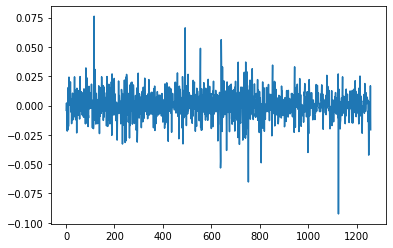

In [46]:
plt.plot(df['returns']);

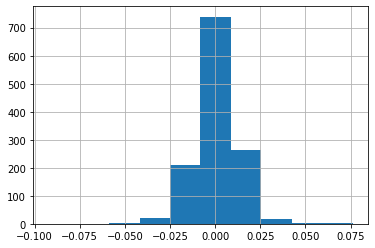

In [47]:
df['returns'].hist()

In [48]:
# One-Step Prediction

# Seprate the "returns" data from the df
# As the first data is NaN we begin with the 2nd data
series = df["returns"].values[1:].reshape(-1, 1) # We make it (N x 1) so than we can apply StandardScaler to it

# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten() # flatten: (1259,1) -> (1259,)

In [49]:
# Build the dataset
# Let's see if we can predict the next price using the T previous data
T = 20
D = 1 # Here we only use "close" price
X = []
Y = []

for t in range(len(series)-T):
  X.append(series[t:t+T])
  Y.append(series[t+T])
X = np.array(X).reshape(-1, T, D) # Reshape it to the size (N x T x D)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [50]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super().__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.lstm = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    
    self.fc = nn.Linear(in_features=self.M, out_features=self.K)

  def forward(self, X):
    # LSTM layer
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out, _ = self.lstm(X, (h0, c0))

    # Dense layer
    # We only want h(T) at the final step
    out = self.fc(out[:,-1,:])
    
    return out

In [51]:
model = RNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [52]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [53]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 50 == 0:
            print(f"Epoch {it+1}/{epochs}, Train_loss: {train_losses[it]:.4f}, Test_loss: {test_losses[it]:.4f}")
    
    return train_losses, test_losses

In [54]:
# Make inputs and outputs target
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

# Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [55]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200)

Epoch 50/200, Train_loss: 0.9329, Test_loss: 1.2634
Epoch 100/200, Train_loss: 0.8451, Test_loss: 1.4625
Epoch 150/200, Train_loss: 0.9086, Test_loss: 1.3136
Epoch 200/200, Train_loss: 0.9040, Test_loss: 1.3159


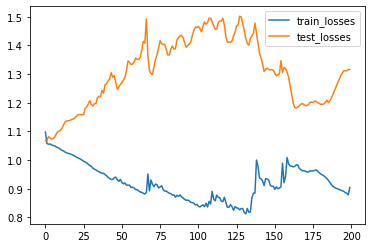

In [56]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()
plt.show()

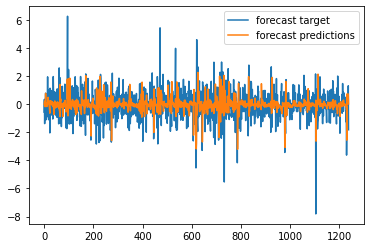

In [57]:
# "One-step" forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0,0].item()
    i += 1
    
    # update the prediction list
    validation_predictions.append(p)

plt.figure()  
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
plt.show()

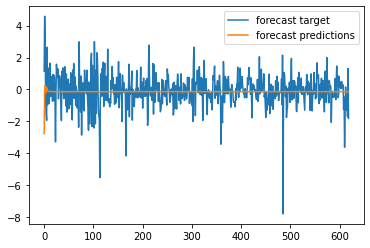

In [58]:
# Multi-step forecast
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    # update the prediction lsit
    validation_predictions.append(p[0,0].item())
    
    # make the new input (from the model forcasts)
    last_x = torch.cat((last_x[1:], p[0]))

plt.figure() 
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
plt.show()